In [1]:
# Attempt to run the full dataset through Integrated Gradients on GPU

In [2]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler

import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import torchvision
from torchvision import datasets, models, transforms
import copy

import numpy as np
import pandas as pd

%matplotlib inline 
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import math
import string

import tqdm

import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.mixture import GaussianMixture

from skimage.filters import sobel
from skimage.color import rgb2gray

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)


cuda:0


In [3]:
#This function takes in a model and replaces inplace relu layers to an independent relu layer
def reluToInplaceFalse(model):
  for name, child in model.named_children():
    if isinstance(child, nn.ReLU):
      setattr(child, 'inplace', False)
    else:
      reluToInplaceFalse(child)

#This is the classifier Class.
from torchvision.transforms.transforms import RandomRotation, RandomAdjustSharpness, RandomGrayscale

class Classifier(torch.nn.Module):

  def __init__(self, backbone='resnet', multi_backbone = False, device ="cuda:0",dropout_rate = 0.2, do_augmentation = False):
    super().__init__()
    self.multi_backbone = multi_backbone # Bool: Indicates if we use multibackbone

    #In the following secttion we download the appropriatee prettrained model
    if backbone == "vgg19":
      backbone = torchvision.models.vgg19(pretrained=True)
      self.out_channels = 25088
      
    elif backbone == "resnet18":
      backbone = torchvision.models.resnet18(pretrained=True)
      self.out_channels = 512

    elif backbone == "resnet50":
      backbone = torchvision.models.resnet50(pretrained=True)
      self.out_channels = 2048

    elif backbone == "Efficientnet b1":
      backbone = torchvision.models.efficientnet_b1(pretrained=True)
      self.out_channels = 1280

    elif backbone == "Efficientnet b3":
      backbone = torchvision.models.efficientnet_b3(pretrained=True)
      self.out_channels = 1536

    elif backbone == "Efficientnet b5":
      backbone = torchvision.models.efficientnet_b5(pretrained=True)
      self.out_channels = 2048

    elif backbone == "Efficientnet b7":
      backbone = torchvision.models.efficientnet_b7(pretrained=True)
      self.out_channels = 2560
      
    # Disabling inplace ReLu becasuse GradCam doesn't work it enabled
    reluToInplaceFalse(backbone)
     
    modules = list(backbone.children())[:-1]
    self.do_augmentation = do_augmentation

    if self.do_augmentation: #If augmentation is enabled we  init tthe layer
      self.augmentation = nn.Sequential(transforms.RandomHorizontalFlip(0.5),
                                        transforms.RandomVerticalFlip(0.5),
                                        # transforms.RandomPerspective(0.2),
                                        transforms.RandomCrop(size=(TARGET_HEIGHT,TARGET_WIDTH)),
                                        transforms.RandomRotation(10, interpolation=transforms.InterpolationMode.BILINEAR),
                                        # RandomAdjustSharpness(,),
                                        # RandomGrayscale(),
                                        # transforms.RandomAutocontrast()
      )

    if self.multi_backbone: #We create the backbones and put them on the device
      self.backbone1 = nn.Sequential(*copy.deepcopy(modules)).to(device)
      self.backbone2 = nn.Sequential(*copy.deepcopy(modules)).to(device)
      self.backbone3 = nn.Sequential(*copy.deepcopy(modules)).to(device)
      self.backbone4 = nn.Sequential(*copy.deepcopy(modules)).to(device)

    else:
      self.backbone =  nn.Sequential(*modules).to(device)


    #This is the final classification layer
    self.fc = nn.Sequential(nn.Dropout(dropout_rate),
                            nn.Linear(self.out_channels * 4, 3))                
     
  def forward(self, x, is_training = True):
    # Transform image range from (0, 1) to (-1, 1)
    x = x * 2 - 1
    if self.do_augmentation and is_training:
      imgs = [self.augmentation(x[:,i]) for i in range(4)] #list of 4 images
    else:
      imgs = [x[:,i] for i in range(4)] #list of 4 images

    if self.multi_backbone:
      encodings = [self.backbone1(imgs[0]).flatten(1), 
                   self.backbone2(imgs[1]).flatten(1),
                   self.backbone3(imgs[2]).flatten(1),
                   self.backbone4(imgs[3]).flatten(1)]
    else:
      encodings = [self.backbone(img).flatten(1) for img in imgs]

    return self.fc(torch.cat(encodings,1))

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Instantiate the classifier using the following weights
# If your directory structure does not resemble the following, you may need to 
model = torch.load("drive/MyDrive/Fish Attribution/" + 'model1e-050.5.2022-05-11 13_52_21.pt', map_location="cpu")
model.eval()
model.zero_grad()

In [6]:
print(torch.cuda.is_available())
# check that cuda is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda:0


In [7]:
# Put the model onto the GPU for faster evaluation
# model.to(device)

In [8]:
# Load the raw fish images
# WARNING: The following WILL use a large amount of RAM
import numpy as np

X_PATH = "/content/drive/Shareddrives/Exploding Gradients/Old Data/x_train_b_cropped_v1.npy"
Y_PATH= "/content/drive/Shareddrives/Exploding Gradients/Old Data/y_train_b_v1.npy"

x = np.load(X_PATH)
y = np.load(Y_PATH)

# 285 instances, currently the shapes are off, see next cell for fix
print(x.shape)
print(y.shape)

(285, 4, 130, 750, 3)
(285, 1)


In [9]:
# Conver to PyTorch tensors from raw numpy arrays and
# fix the dimensions
tensor_x = torch.Tensor(x) 
tensor_y = torch.Tensor(y).long()

tensor_x = torch.swapaxes(tensor_x,2,4)
tensor_x = torch.swapaxes(tensor_x,3,4)

In [10]:
# There are 258 pieces of data, with 4 images per instance
# and each image being full color (RGB) with 130x750 pixels
# (The original fish images are of larger dimension but
# an autocropper was created to narrow down the focus)
tensor_x.shape

torch.Size([285, 4, 3, 130, 750])

In [11]:
# Create a PyTorch dataloader to feed data to the model
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

attribution_ds = TensorDataset(tensor_x ,tensor_y)

#attribution_dl = DataLoader(attribution_ds,10,shuffle = True)

# Delete the raw numpy arrays from RAM, there's no need for them
# now that they exist as PyTorch tensors
del x,y

In [12]:
# Install Captum for Feature Attribution
!pip install -q captum

from captum.attr import *

     |████████████████████████████████| 1.4 MB 5.1 MB/s 


In [13]:
# attempt GPU calculation
print(torch.cuda.is_available())
# check that cuda is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#model.to(device)

gs = GradientShap(model)

all_attributions = []
batch_num = 1
for i in range(5):
  images, labels = attribution_ds[i]
  print(f"Processing batch #{batch_num}")
  batch_num += 1
  # send images to the GPU
  #images = images.to(device)
  attributions = gs.attribute(images.unsqueeze(0), target=labels, baselines = (images.unsqueeze(0) * 0))
  all_attributions.append(attributions.cpu())
  del images, labels, attributions
  torch.cuda.empty_cache()

True
cuda:0
Processing batch #1
Processing batch #2
Processing batch #3
Processing batch #4
Processing batch #5


In [14]:
images.unsqueeze(0).unsqueeze(0).shape

NameError: ignored

tensor([1])


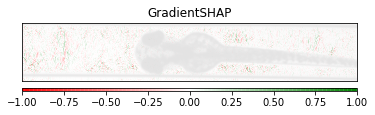

tensor([2])


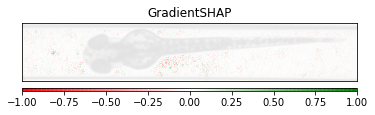

tensor([1])


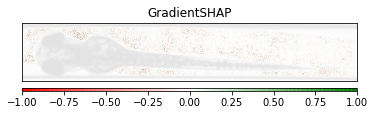

tensor([1])


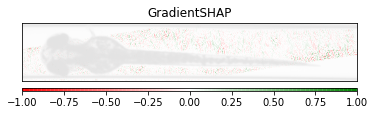

tensor([1])


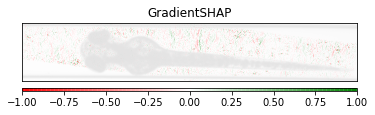

tensor([2])


IndexError: ignored

In [16]:
from captum.attr import visualization as viz

for i in range(10):
  image, label = attribution_ds[i]
  print(label)
  _ = viz.visualize_image_attr(all_attributions[i].squeeze()[0].permute(1,2,0).detach().numpy(), image.squeeze()[0].permute(1,2,0).detach().numpy(), method="blended_heat_map", sign="all", alpha_overlay=0.9,
                          show_colorbar=True, title="GradientSHAP")